# Runtime Benchmark: Conformal Prediction Methods

This notebook benchmarks the runtime performance of:
1. **Standard CP** - One forward pass (prediction)
2. **Adaptive CP (Local CP)** - Calibration pass (quantile network training)

We'll measure runtime across different:
- Dataset sizes
- Input dimensions
- Model complexities

In [63]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
from typing import Dict, List

from local_cp import CP, AdaptiveCP

sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

torch.set_num_threads(3)

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Detect device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
print("✓ Imports successful!")

Using device: mps
PyTorch version: 2.10.0
✓ Imports successful!


## 1. Define Simple Neural Network

In [64]:
class SimpleNN(nn.Module):
    """Simple feedforward neural network for regression."""
    
    def __init__(self, input_dim=2, hidden_dims=[64, 64], output_dim=1):
        super().__init__()
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.Tanh()
            ])
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, output_dim))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x, return_hidden=False):
        if return_hidden:
            # Return output and last hidden layer
            for i, layer in enumerate(self.network[:-1]):
                x = layer(x)
            hidden = x
            output = self.network[-1](x)
            return output, hidden
        else:
            return self.network(x)

print("✓ Model defined")

✓ Model defined


## 2. Data Generation Function

In [65]:
def generate_synthetic_data(n_samples, input_dim=2, seed=42):
    """Generate synthetic regression data."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Generate features
    X = 2 * torch.rand(n_samples, input_dim) - 1  # [-1, 1]^d
    
    # Generate targets (simple nonlinear function)
    Y = torch.sum(torch.sin(3 * X), dim=1, keepdim=True)
    Y = Y + 0.1 * torch.randn_like(Y)  # Add noise
    
    return X, Y

# Test data generation
X_test, Y_test = generate_synthetic_data(100)
print(f"Generated test data: X shape {X_test.shape}, Y shape {Y_test.shape}")

Generated test data: X shape torch.Size([100, 2]), Y shape torch.Size([100, 1])


## 3. Simple Model Training

In [66]:
def train_simple_model(model, X_train, Y_train, epochs=1000, lr=1e-3, verbose=False):
    """Quick training for benchmark purposes."""
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    X_train = X_train.to(model.network[0].weight.device)
    Y_train = Y_train.to(model.network[0].weight.device)
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        Y_pred = model(X_train)
        loss = criterion(Y_pred, Y_train)
        loss.backward()
        optimizer.step()
        
        if verbose and (epoch + 1) % 200 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4e}")
    
    model.eval()
    return model

print("✓ Training function defined")

✓ Training function defined


## 4. Benchmark Functions

In [67]:
def benchmark_cp_predict(cp_model, X_test, X_train, Y_train, X_cal, Y_cal, 
                         alpha=0.1, heuristic='feature', k=20, n_runs=50, n_warmup=3):
    """
    Benchmark CP forward pass (prediction).
    
    Returns
    -------
    median_time : float
        Median runtime in seconds.
    q25_time : float
        25th percentile of runtime.
    q75_time : float
        75th percentile of runtime.
    """
    # Warm-up runs (not timed)
    for _ in range(n_warmup):
        _ = cp_model.predict(
            alpha=alpha,
            X_test=X_test,
            X_train=X_train,
            Y_train=Y_train,
            X_cal=X_cal,
            Y_cal=Y_cal,
            heuristic=heuristic,
            k=k
        )
    
    # Timed runs
    times = []
    for _ in range(n_runs):
        start = time.time()
        lower, upper = cp_model.predict(
            alpha=alpha,
            X_test=X_test,
            X_train=X_train,
            Y_train=Y_train,
            X_cal=X_cal,
            Y_cal=Y_cal,
            heuristic=heuristic,
            k=k
        )
        times.append(time.time() - start)
    
    return np.median(times), np.percentile(times, 25), np.percentile(times, 75)


def benchmark_adaptive_cp_calibration(model, X_cal, Y_cal, X_train, Y_train,
                                     alpha=0.1, heuristic='feature', k=20,
                                     epochs=5000, n_runs=5):
    """
    Benchmark Adaptive CP calibration (quantile network training).
    
    Returns
    -------
    mean_time : float
        Mean runtime in seconds.
    std_time : float
        Standard deviation of runtime.
    """
    times = []
    
    for _ in range(n_runs):
        # Create new AdaptiveCP instance each time to re-train from scratch
        adaptive_cp = AdaptiveCP(
            model=model,
            alpha=alpha,
            device=device,
            heuristic=heuristic,
            hidden_layers=(64, 64, 64),
            learning_rate=5e-4,
            epochs=epochs,
            step_size=epochs//4,
            gamma=0.5,
            quant_seed=42
        )
        
        # Time the first predict call (which triggers training)
        start = time.time()
        _ = adaptive_cp.predict(
            alpha=alpha,
            X_test=X_cal[:10],  # Small test set just to trigger training
            X_train=X_train,
            Y_train=Y_train,
            X_cal=X_cal,
            Y_cal=Y_cal,
            k=k,
            verbose=False
        )
        end = time.time()
        times.append(end - start)
    
    return np.mean(times), np.std(times)

print("✓ Benchmark functions defined")

✓ Benchmark functions defined


## 5. Runtime Benchmarks (α=0.05)

We'll benchmark three key aspects:
1. **Data size scaling**: How runtime changes with dataset size
2. **Quantile network complexity**: Effect of quantile network architecture on runtime

In [68]:
def benchmark_inference_only(model, X_test, X_train, Y_train, X_cal, Y_cal, 
                            alpha=0.05, heuristic='feature', k=20, n_runs=50,
                            hidden_layers=(64, 64, 64), n_warmup=5):
    """Benchmark AdaptiveCP inference time (after calibration)."""
    # First calibrate
    adaptive_cp = AdaptiveCP(
        model=model, alpha=alpha, device=device, heuristic=heuristic,
        hidden_layers=hidden_layers, learning_rate=5e-4, epochs=2000,
        step_size=500, gamma=0.5, quant_seed=42
    )
    # Trigger calibration (not timed)
    _ = adaptive_cp.predict(alpha=alpha, X_test=X_test[:10], X_train=X_train,
                           Y_train=Y_train, X_cal=X_cal, Y_cal=Y_cal, k=k, verbose=False)
    
    # Warm-up runs (not timed)
    for _ in range(n_warmup):
        _ = adaptive_cp.predict(alpha=alpha, X_test=X_test, X_train=X_train,
                               Y_train=Y_train, X_cal=X_cal, Y_cal=Y_cal, k=k, verbose=False)
    
    # Timed runs
    times = []
    for _ in range(n_runs):
        start = time.time()
        _ = adaptive_cp.predict(alpha=alpha, X_test=X_test, X_train=X_train,
                               Y_train=Y_train, X_cal=X_cal, Y_cal=Y_cal, k=k, verbose=False)
        times.append(time.time() - start)
    return np.median(times), np.percentile(times, 25), np.percentile(times, 75)


def benchmark_initialization_only(model, X_cal, Y_cal, X_train, Y_train,
                                  alpha=0.05, heuristic='feature', k=20, epochs=2000, n_runs=3,
                                  hidden_layers=(64, 64, 64)):
    """Benchmark AdaptiveCP initialization/calibration time."""
    times = []
    for _ in range(n_runs):
        adaptive_cp = AdaptiveCP(
            model=model, alpha=alpha, device=device, heuristic=heuristic,
            hidden_layers=hidden_layers, learning_rate=5e-4, epochs=epochs,
            step_size=epochs//4, gamma=0.5, quant_seed=42
        )
        start = time.time()
        _ = adaptive_cp.predict(alpha=alpha, X_test=X_cal[:10], X_train=X_train,
                               Y_train=Y_train, X_cal=X_cal, Y_cal=Y_cal, k=k, verbose=False)
        times.append(time.time() - start)
    return np.mean(times), np.std(times)


alpha = 0.05

# ============================================================
# Benchmark 1: Varying Dataset Size
# ============================================================
print("="*70)
print("BENCHMARK 1: Varying Dataset Size")
print("="*70)

data_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800]
results_size = {
    'n_samples': [],
    'cp_inference_median': [], 'cp_inference_q25': [], 'cp_inference_q75': [],
    'adaptive_init_mean': [], 'adaptive_init_std': [],
    'adaptive_inference_median': [], 'adaptive_inference_q25': [], 'adaptive_inference_q75': []
}

print(f"Running benchmarks at α={alpha}...\n")

for n_samples in data_sizes:
    print(f"Dataset size: {n_samples}...", end=' ')
    
    # Generate and split data
    X_all, Y_all = generate_synthetic_data(n_samples * 2, input_dim=2)
    n_train, n_cal = n_samples, n_samples // 2
    X_train, Y_train = X_all[:n_train], Y_all[:n_train]
    X_cal, Y_cal = X_all[n_train:n_train+n_cal], Y_all[n_train:n_train+n_cal]
    X_test = X_all[n_train+n_cal:n_train+n_cal+100]
    
    # Train model
    model = SimpleNN(input_dim=2, hidden_dims=[64, 64]).to(device)
    model = train_simple_model(model, X_train, Y_train, epochs=500, verbose=False)
    
    # CP inference
    cp = CP(model=model, device=device)
    cp_median, cp_q25, cp_q75 = benchmark_cp_predict(
        cp, X_test, X_train, Y_train, X_cal, Y_cal,
        alpha=alpha, heuristic='feature', k=20, n_runs=50
    )
    
    # Adaptive CP initialization
    init_mean, init_std = benchmark_initialization_only(
        model, X_cal, Y_cal, X_train, Y_train,
        alpha=alpha, heuristic='feature', k=20, epochs=2000, n_runs=10
    )
    
    # Adaptive CP inference
    inf_median, inf_q25, inf_q75 = benchmark_inference_only(
        model, X_test, X_train, Y_train, X_cal, Y_cal,
        alpha=alpha, heuristic='feature', k=20, n_runs=100
    )
    
    results_size['n_samples'].append(n_samples)
    results_size['cp_inference_median'].append(cp_median)
    results_size['cp_inference_q25'].append(cp_q25)
    results_size['cp_inference_q75'].append(cp_q75)
    results_size['adaptive_init_mean'].append(init_mean)
    results_size['adaptive_init_std'].append(init_std)
    results_size['adaptive_inference_median'].append(inf_median)
    results_size['adaptive_inference_q25'].append(inf_q25)
    results_size['adaptive_inference_q75'].append(inf_q75)
    
    print(f"Done!")

print("\n✓ Benchmark 1 complete!\n")


# ============================================================
# Benchmark 2: Varying Quantile Network Complexity
# ============================================================
print("="*70)
print("BENCHMARK 2: Varying Quantile Network Complexity")
print("="*70)

# Fixed dataset size
n_samples_fixed = 500
X_all, Y_all = generate_synthetic_data(n_samples_fixed * 2, input_dim=2)
n_train, n_cal = n_samples_fixed, n_samples_fixed // 2
X_train_fixed = X_all[:n_train]
Y_train_fixed = Y_all[:n_train]
X_cal_fixed = X_all[n_train:n_train+n_cal]
Y_cal_fixed = Y_all[n_train:n_train+n_cal]
X_test_fixed = X_all[n_train+n_cal:n_train+n_cal+100]

# Train fixed model
model_fixed = SimpleNN(input_dim=2, hidden_dims=[64, 64]).to(device)
model_fixed = train_simple_model(model_fixed, X_train_fixed, Y_train_fixed, epochs=500, verbose=False)

# Benchmark CP inference time (constant across all architectures)
cp_fixed = CP(model=model_fixed, device=device)
cp_median_fixed, cp_q25_fixed, cp_q75_fixed = benchmark_cp_predict(
    cp_fixed, X_test_fixed, X_train_fixed, Y_train_fixed, X_cal_fixed, Y_cal_fixed,
    alpha=alpha, heuristic='feature', k=20, n_runs=50
)
print(f"CP inference time: {cp_median_fixed:.6f}s (median)\n")

# Different quantile network architectures (varying depth with fixed width of 64)
architectures = [
    (64,),                      # 1 layer
    (64, 64),                   # 2 layers
    (64, 64, 64),               # 3 layers
    (64, 64, 64, 64),           # 4 layers
    (64, 64, 128, 64, 64),       # 5 layers
    (64, 64, 128, 128, 64, 64),    # 6 layers
    (64, 64, 128, 128, 128, 128, 64, 64),  # 7 layers
    (64, 64, 128, 128, 256, 128, 128, 64, 64)  # 8 layers
]

def count_params(hidden_layers, input_dim, output_dim=2):
    """Count total parameters in quantile network."""
    total = 0
    prev_dim = input_dim
    for h in hidden_layers:
        total += prev_dim * h + h  # weights + bias
        prev_dim = h
    total += prev_dim * output_dim + output_dim  # output layer
    return total

# Get input dimension (depends on heuristic)
# For 'feature' heuristic with k=20, it's the feature dimension
input_dim_quant = 2  # feature dimension

results_complexity = {
    'architecture': [],
    'n_params': [],
    'init_mean': [], 'init_std': [],
    'inference_median': [], 'inference_q25': [], 'inference_q75': []
}

print(f"Running benchmarks with fixed dataset size = {n_samples_fixed}...\n")

for arch in architectures:
    n_params = count_params(arch, input_dim_quant)
    arch_str = f"({', '.join(map(str, arch))})"
    print(f"Architecture {arch_str} ({n_params:,} params)...", end=' ')
    
    # Benchmark initialization
    init_mean, init_std = benchmark_initialization_only(
        model_fixed, X_cal_fixed, Y_cal_fixed, X_train_fixed, Y_train_fixed,
        alpha=alpha, heuristic='feature', k=20, epochs=2000, n_runs=10,
        hidden_layers=arch
    )
    
    # Benchmark inference
    inf_median, inf_q25, inf_q75 = benchmark_inference_only(
        model_fixed, X_test_fixed, X_train_fixed, Y_train_fixed, X_cal_fixed, Y_cal_fixed,
        alpha=alpha, heuristic='feature', k=20, n_runs=100,
        hidden_layers=arch
    )
    
    results_complexity['architecture'].append(arch_str)
    results_complexity['n_params'].append(n_params)
    results_complexity['init_mean'].append(init_mean)
    results_complexity['init_std'].append(init_std)
    results_complexity['inference_median'].append(inf_median)
    results_complexity['inference_q25'].append(inf_q25)
    results_complexity['inference_q75'].append(inf_q75)
    
    print(f"Done!")

print("\n✓ Benchmark 2 complete!")

BENCHMARK 1: Varying Dataset Size
Running benchmarks at α=0.05...

Dataset size: 100... 

KeyboardInterrupt: 

## 6. Results & Visualization

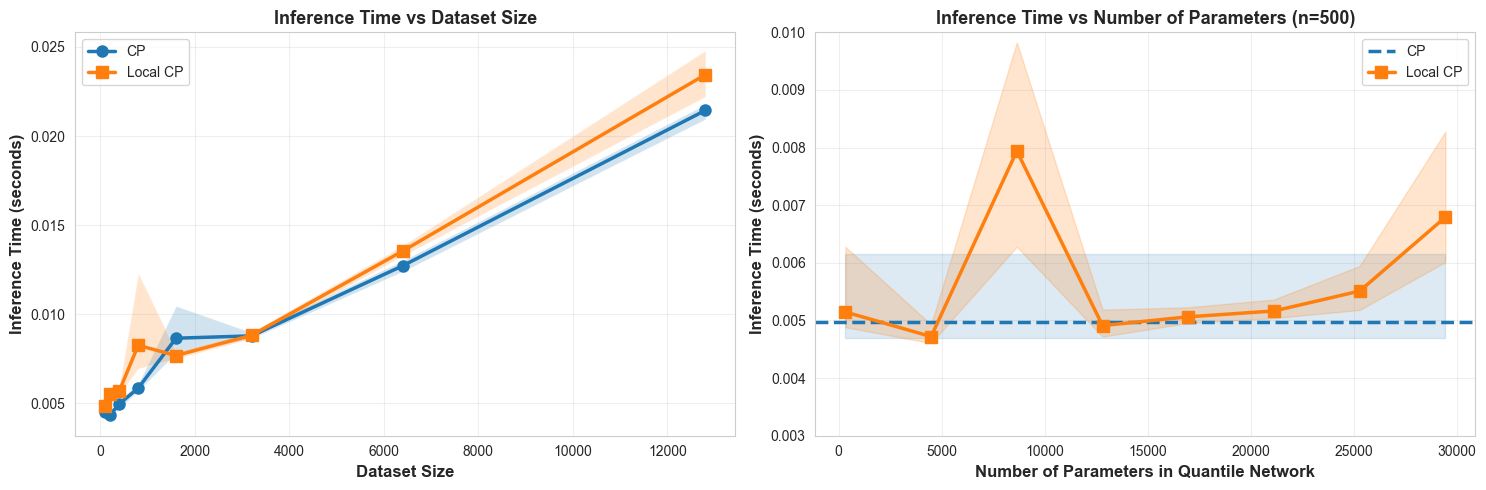

In [ ]:
df_size = pd.DataFrame(results_size)
df_complexity = pd.DataFrame(results_complexity)

# Configure plot ranges (set to None for auto-range)
# Plot 1: Dataset Size
plot1_xlim = None  
plot1_ylim = None 

# Plot 2: Quantile Network Complexity
plot2_xlim = None  
plot2_ylim = (0.003, 0.01)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Inference Time vs Dataset Size
ax1.plot(df_size['n_samples'], df_size['cp_inference_median'], 
         marker='o', linewidth=2.5, markersize=8, label='CP')
ax1.fill_between(df_size['n_samples'], 
                 df_size['cp_inference_q25'],
                 df_size['cp_inference_q75'],
                 alpha=0.2)

ax1.plot(df_size['n_samples'], df_size['adaptive_inference_median'], 
         marker='s', linewidth=2.5, markersize=8, label='Local CP')
ax1.fill_between(df_size['n_samples'],
                 df_size['adaptive_inference_q25'],
                 df_size['adaptive_inference_q75'],
                 alpha=0.2)

ax1.set_xlabel('Dataset Size', fontsize=12, fontweight='bold')
ax1.set_ylabel('Inference Time (seconds)', fontsize=12, fontweight='bold')
ax1.set_title('Inference Time vs Dataset Size', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
if plot1_xlim is not None:
    ax1.set_xlim(plot1_xlim)
if plot1_ylim is not None:
    ax1.set_ylim(plot1_ylim)

# Plot 2: Inference Time vs Quantile Network Complexity
# Add CP baseline (constant)
ax2.axhline(y=cp_median_fixed, color='C0', linestyle='--', linewidth=2.5, label='CP')
ax2.fill_between(df_complexity['n_params'], 
                 cp_q25_fixed, cp_q75_fixed,
                 color='C0', alpha=0.15)

ax2.plot(df_complexity['n_params'], df_complexity['inference_median'], 
         marker='s', linewidth=2.5, markersize=8, label='Local CP', color='C1')
ax2.fill_between(df_complexity['n_params'],
                 df_complexity['inference_q25'],
                 df_complexity['inference_q75'],
                 alpha=0.2, color='C1')

ax2.set_xlabel('Number of Parameters in Quantile Network', fontsize=12, fontweight='bold')
ax2.set_ylabel('Inference Time (seconds)', fontsize=12, fontweight='bold')
ax2.set_title(f'Inference Time vs Number of Parameters (n={n_samples_fixed})', 
              fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
if plot2_xlim is not None:
    ax2.set_xlim(plot2_xlim)
if plot2_ylim is not None:
    ax2.set_ylim(plot2_ylim)

plt.tight_layout()
plt.show()
